In [1]:
import pandas as pd
import sqlite3

import re

from pydantic import BaseModel
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
from copy import deepcopy 

In [2]:
db_path = '/Users/samarnesen/Library/Messages/chat.db'

conn = sqlite3.connect(db_path)

query = '''
SELECT
    message.rowid, 
    message.handle_id, 
    message.text, 
    message.date, 
    message.is_from_me, 
    handle.id as phone_number
FROM 
    message 
LEFT JOIN 
    handle 
ON 
    message.handle_id = handle.rowid
'''

messages_df = pd.read_sql_query(query, conn)

conn.close()

In [3]:
def convert_timestamp(ts):
    apple_timestamp_seconds = ts / 1e9
    unix_timestamp_seconds = apple_timestamp_seconds + 978307200
    return pd.to_datetime(unix_timestamp_seconds, unit='s').date().strftime('%m/%d/%Y')

In [4]:
def row_to_name(row):
    if row.is_from_me:
        return "Sam"
    elif row.phone_number == "+17736776717":
        return "Will"
    elif row.phone_number == "+17734281342":
        return "Rachel"
    elif row.phone_number == "+19087311244":
        return "Keith"

color_map = {"Sam": "red", "Keith": "blue", "Will": "purple", "Rachel": "green"}

In [5]:
class DataObj(BaseModel):
    correct: int
    score: int
    date: str
    matrix: list[list[bool]] = None
    text: str

In [6]:
texts = {}
reversed = {}
current_grid_number = 0
for idx, row in messages_df[["text", "date", "phone_number", "is_from_me"]].iterrows():
    name = row_to_name(row)
    if name and row.text and "Rarity:" in row.text and "Emphasized" not in row.text and "Laughed at" not in row.text and "Loved" not in row.text and "Questioned" not in row.text and "Liked" not in row.text and "Disliked" not in row.text and "🏀" not in row.text:
        try:
            parsed = re.search(r"Immaculate Grid (\d+) (\d)/\d", row.text).groups()
        except Exception as e:
            continue
        grid_number = int(parsed[0])
        correct = int(parsed[1])
        score = int(re.search(r"Rarity: (\d{1,3})", row.text).groups()[0])
        date = convert_timestamp(row.date)

        # get specific correctness
        matrix = []
        for text_row in row.text.split("\n"):
            current = []
            for char in text_row:
                if ord(char) == 11036: #"⬜️":
                    current.append(False)
                elif ord(char) == 129001: #"🟩":
                    current.append(True)
            if len(current) > 0:
                if len(current) != 3:
                    print(row.text)
                    assert len(current) == 3
                else:
                    matrix.append(current)
        assert len(matrix) == 3

        obj = DataObj(correct=correct, score=score, date=date, matrix=matrix, text=row.text)
        if name not in texts or grid_number not in texts[name] or (name in texts and grid_number in texts[name] and texts[name][grid_number].correct == correct):
            texts.setdefault(name, {}).setdefault(grid_number, obj)
            reversed.setdefault(grid_number, {}).setdefault(name, obj)
        if grid_number >= current_grid_number:
            current_grid_number = grid_number

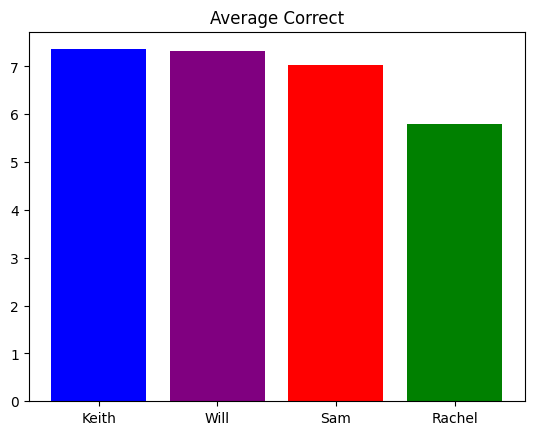

In [7]:
# Graph average correct
average_correct = []
for person in texts:
    data = [obj.correct for obj in texts[person].values()]
    average_correct.append(sum(data) / len(data))
plt.bar([person for person in texts], average_correct, color=[color_map[person] for person in texts])
plt.title("Average Correct")
plt.show()

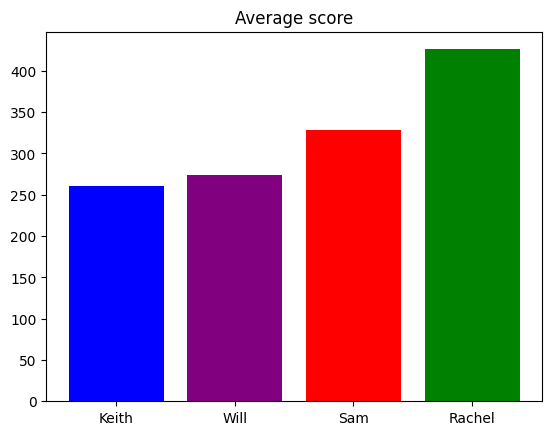

In [8]:
# Graph average score
average_score = []
for person in texts:
    data = [obj.score for obj in texts[person].values()]
    average_score.append(sum(data) / len(data))
plt.bar([person for person in texts], average_score, color=[color_map[person] for person in texts])
plt.title("Average score")
plt.show()

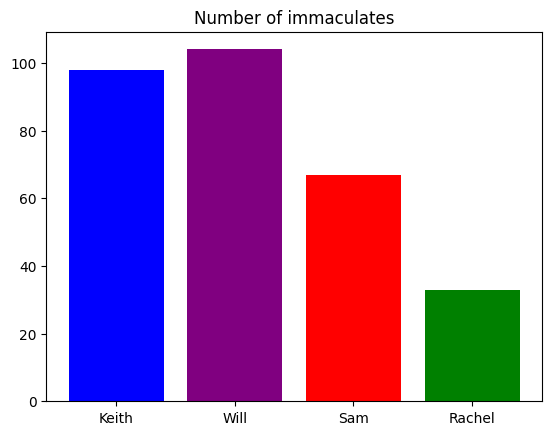

In [9]:
# Graph number of immaculates
counts = []
for person in texts:
    data = [(1 if obj.correct == 9 else 0) for obj in texts[person].values()]
    counts.append(sum(data))
plt.bar([person for person in texts], counts, color=[color_map[person] for person in texts])
plt.title("Number of immaculates")
plt.show()

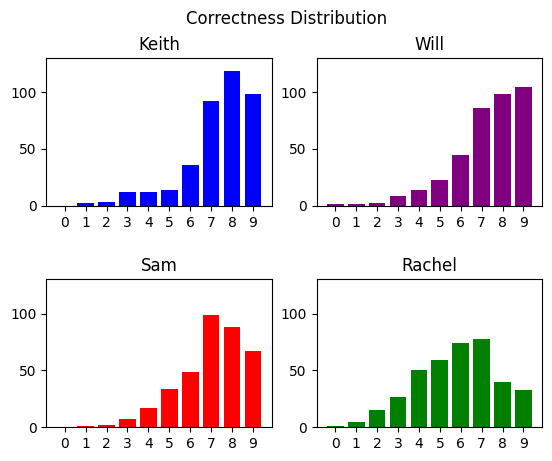

In [10]:
# Graph distributions
fig, axs = plt.subplots(2, 2)
top_bar = 130
for i, person in enumerate(texts):
    idx = [0, 0] if i == 0 else ([0, 1] if i == 1 else ([1, 0] if i == 2 else [1, 1]))
    distribution = [0 for i in range(0, 10)]
    for row in texts[person].values():
        distribution[row.correct] += 1
    axs[idx[0], idx[1]].bar(range(0, 10), distribution, color=color_map[person])
    axs[idx[0], idx[1]].set_xticks(range(0,10))
    #axs[idx[0], idx[1]].set_yticks(range(0, top_bar + 1, 5))
    axs[idx[0], idx[1]].set_title(person)
    axs[idx[0], idx[1]].set_ylim(0, top_bar)

fig.suptitle("Correctness Distribution")
plt.subplots_adjust(hspace=0.5)
plt.show()

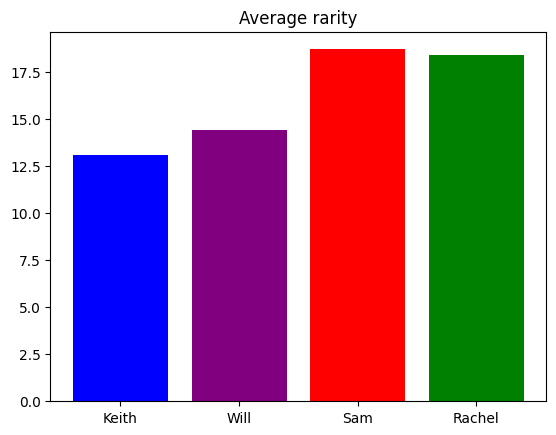

In [11]:
average_rarity = []
for person in texts:
    total_correct_scores = 0
    total_correct = 0
    for obj in texts[person].values():
        total_correct_scores += obj.score - (100 * (9 - obj.correct))
        total_correct += obj.correct
    average_rarity.append(total_correct_scores / total_correct)
plt.bar([person for person in texts], average_rarity, color=[color_map[person] for person in texts])
plt.title("Average rarity")
plt.show()

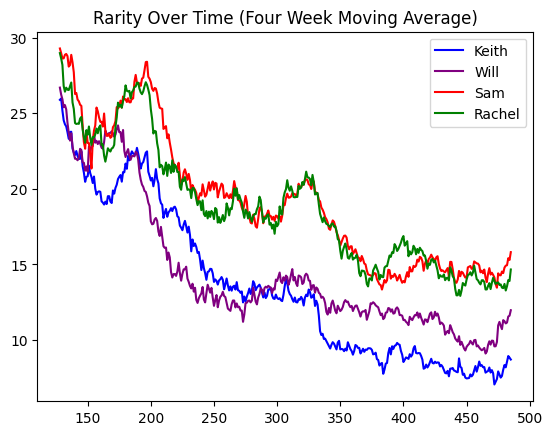

In [12]:
min_range = 100
smoothness = 28
average_rarity = []
for person in texts:
    total_correct_scores = []
    total_correct = []
    for i in range(current_grid_number):
        if i in texts[person] and (texts[person][i].score < 900 or texts[person][i].correct == 0):
            obj = texts[person][i]
            total_correct_scores.append(obj.score - (100 * (9 - obj.correct)))
            total_correct.append(obj.correct)
        else:
            total_correct_scores.append(None)
            total_correct.append(None)

    smoothed_scores = []
    range_val = []
    for i in range(min_range + smoothness, current_grid_number):
        score_sub = [x for x in filter(lambda x: x is not None, total_correct_scores[i - smoothness:i])]
        correct_sub = [x for x in filter(lambda x: x is not None, total_correct[i - smoothness:i])]
        if correct_sub:
            smoothed_scores.append(sum(score_sub) / sum(correct_sub))
            range_val.append(i)

    plt.plot(range_val, smoothed_scores, label=person, color=color_map[person])
plt.legend()
plt.title("Rarity Over Time (Four Week Moving Average)")
plt.show()

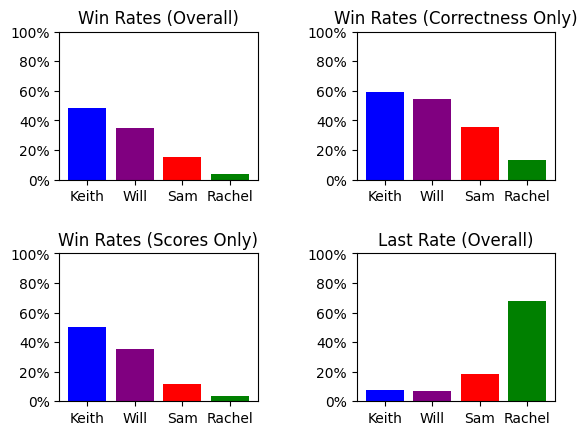

In [13]:
def to_percent(y, position):
    return f"{100 * y:.0f}%"

fig, axs = plt.subplots(2, 2)

wins = {person: 0 for person in texts}
for game in reversed.values():
    best = 0
    for person in game:
        effective_score = (game[person].correct * 1000) + (1000 - game[person].score)
        if effective_score > best:
            best = effective_score
    for person in game:
        effective_score = (game[person].correct * 1000) + (1000 - game[person].score)
        if effective_score == best:
            wins[person] += 1
for person in wins:
    wins[person] /= len(reversed.values())

axs[0, 0].bar([person for person in wins], wins.values(), color=[color_map[person] for person in wins])
axs[0, 0].set_title("Win Rates (Overall)")

wins = {person: 0 for person in texts}
for game in reversed.values():
    best = 0
    for person in game:
        if game[person].correct > best:
            best = game[person].correct
    for person in game:
        if game[person].correct == best:
            wins[person] += 1
for person in wins:
    wins[person] /= len(reversed.values())
axs[0, 1].bar([person for person in wins], wins.values(), color=[color_map[person] for person in wins])
axs[0, 1].set_title("Win Rates (Correctness Only)")

wins = {person: 0 for person in texts}
for game in reversed.values():
    best = float("inf")
    for person in game:
        if game[person].score < best:
            best = game[person].score
    for person in game:
        if game[person].score == best:
            wins[person] += 1
for person in wins:
    wins[person] /= len(reversed.values())
axs[1, 0].bar([person for person in wins], wins.values(), color=[color_map[person] for person in wins])
axs[1, 0].set_title("Win Rates (Scores Only)")

wins = {person: 0 for person in texts}
for game in reversed.values():
    best = float("inf")
    for person in game:
        effective_score = (game[person].correct * 1000) + (1000 - game[person].score)
        if effective_score < best:
            best = effective_score
    for person in game:
        effective_score = (game[person].correct * 1000) + (1000 - game[person].score)
        if effective_score == best:
            wins[person] += 1
for person in wins:
    wins[person] /= len(reversed.values())

axs[1, 1].bar([person for person in wins], wins.values(), color=[color_map[person] for person in wins])
axs[1, 1].set_title("Last Rate (Overall)")

for ax in axs.flat:
    ax.set_yticks([i / 5 for i in range(6)])
    ax.set_ylim(0, 1)
    ax.yaxis.set_major_formatter(FuncFormatter(to_percent))

plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.5)
plt.show()

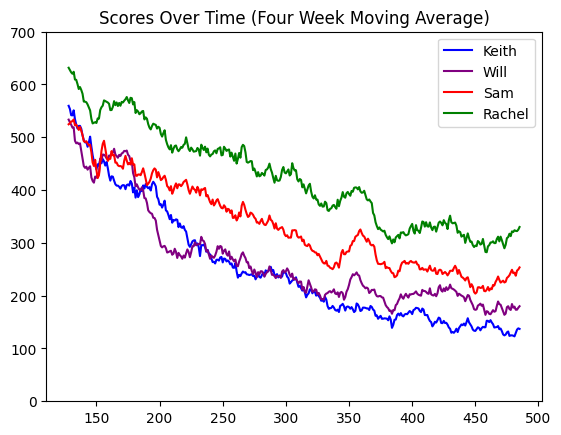

In [14]:
min_range = 100
smoothness = 28
average_rarity = []
for person in texts:
    total_scores = []
    for i in range(current_grid_number):
        if i in texts[person] and (texts[person][i].score < 900 or texts[person][i].correct == 0):
            obj = texts[person][i]
            total_scores.append(obj.score)
        else:
            total_scores.append(None)

    smoothed_scores = []
    range_val = []
    for i in range(min_range + smoothness, current_grid_number):
        score_sub = [x for x in filter(lambda x: x is not None, total_scores[i - smoothness:i])]
        if score_sub:
            smoothed_scores.append(sum(score_sub) / len(score_sub))
            range_val.append(i)

    plt.plot(range_val, smoothed_scores, label=person, color=color_map[person])
plt.legend()
plt.ylim(0, 700)
plt.title("Scores Over Time (Four Week Moving Average)")
plt.show()

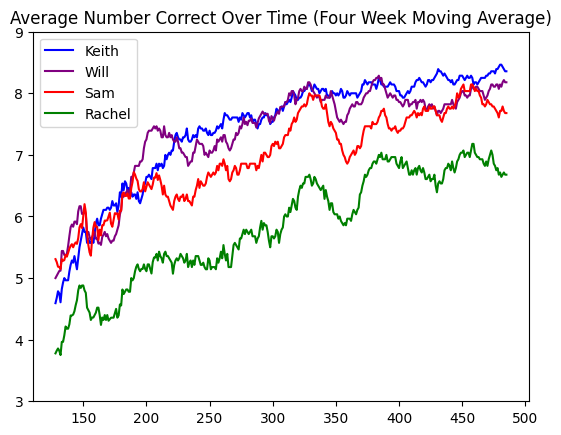

In [15]:
min_range = 100
smoothness = 28
average_rarity = []
for person in texts:
    total_scores = []
    for i in range(current_grid_number):
        if i in texts[person] and (texts[person][i].score < 900 or texts[person][i].correct == 0):
            obj = texts[person][i]
            total_scores.append(obj.correct)
        else:
            total_scores.append(None)

    smoothed_scores = []
    range_val = []
    for i in range(min_range + smoothness, current_grid_number):
        score_sub = [x for x in filter(lambda x: x is not None, total_scores[i - smoothness:i])]
        if score_sub:
            smoothed_scores.append(sum(score_sub) / len(score_sub))
            range_val.append(i)

    plt.plot(range_val, smoothed_scores, label=person, color=color_map[person])
plt.legend()
plt.ylim(3, 9)
plt.title("Average Number Correct Over Time (Four Week Moving Average)")
plt.show()

In [16]:
restructured = []
for person in texts:
    for grid_number, obj in texts[person].items():
        restructured.append({"person": person, "game": grid_number, "correct": obj.correct, "score": obj.score, "date": obj.date})
csv_df = pd.DataFrame(restructured)

In [17]:
csv_df.to_csv("./immaculate_grid_stats.csv")

In [18]:
score_records = []
for person, games in texts.items():
    for id, game in games.items():
        score_records.append((person, game.score, game.date, id))

print("Best:")
sorted_records = sorted(score_records, key=lambda x: x[1])
for i, (name, record, date, game_id) in enumerate(sorted_records[0:25]):
    print(i + 1, name, record, date)

print("\n\nWorst:")
for i in range(25):
    name, record, date, game_id = sorted_records[len(sorted_records) - i - 1]
    print(i + 1, name, record, date)

Best:
1 Keith 4 06/14/2024
2 Keith 8 06/28/2024
3 Will 8 07/13/2024
4 Will 9 10/28/2023
5 Will 10 01/15/2024
6 Will 12 04/27/2024
7 Keith 14 07/21/2024
8 Will 14 06/14/2024
9 Rachel 15 07/13/2024
10 Keith 17 02/28/2024
11 Will 18 05/28/2024
12 Keith 20 07/13/2024
13 Will 20 12/30/2023
14 Keith 21 03/24/2024
15 Keith 21 04/25/2024
16 Keith 21 06/05/2024
17 Will 22 11/11/2023
18 Keith 23 06/02/2024
19 Will 23 06/02/2024
20 Sam 23 06/02/2024
21 Keith 24 04/01/2024
22 Will 24 02/08/2024
23 Will 24 05/04/2024
24 Will 25 06/22/2024
25 Will 26 07/21/2024


Worst:
1 Rachel 900 09/01/2023
2 Will 900 09/01/2023
3 Will 900 01/06/2024
4 Rachel 891 08/30/2023
5 Rachel 852 11/20/2023
6 Rachel 833 07/15/2023
7 Keith 828 08/30/2023
8 Rachel 825 07/28/2023
9 Rachel 825 12/22/2023
10 Will 825 07/28/2023
11 Rachel 823 08/01/2023
12 Sam 821 07/15/2023
13 Will 821 07/15/2023
14 Keith 821 07/15/2023
15 Sam 817 11/02/2023
16 Rachel 806 12/28/2023
17 Rachel 805 07/13/2023
18 Will 805 07/21/2023
19 Keith 805 0

In [96]:
with open("/Users/samarnesen/Desktop/immaculate_grid_prompt_data.csv") as f:
    prompt_df = pd.read_csv(f, header=None)
prompt_df.columns = ["game_id", "00", "01", "02", "10", "11", "12", "20", "21", "22"]
prompt_df = prompt_df.iloc[1:]

new_rows = []
for i, row in prompt_df.iterrows():
    new_row = {}
    for col, val in row.items():
        for char in ["(", "'", ")"]:
            val = val.replace(char, "")
        new_row[col] = val.replace(", ", " + ")
    new_rows.append(new_row)
        

prompt_df = pd.DataFrame(new_rows)
prompt_df['game_id'] = prompt_df['game_id'].astype(int)

In [101]:
team_list = ["Cubs", "Cardinals", "Brewers", "Reds", "Pirates", "Nationals", "Mets", "Marlins", "Phillies", "Braves", "Dodgers", "Diamondbacks", "Rockies", "Giants", "Padres", "Royals", "White Sox", "Twins", "Guardians", "Tigers", "Red Sox", "Yankees", "Blue Jays", "Rays", "Orioles", "Angels", "Athletics", "Astros", "Mariners", "Rangers"]

def is_team(category):
    for team in team_list:
        if team in category:
            return True
    return False

def get_team(category):
    for team in team_list:
        if team in category:
            return team
    return ""

In [80]:
def get_categories(prompt):
    parts = prompt.split(" + ")
    return parts[0].strip(), parts[1].strip()

categories = set()
for person, games in texts.items():
    for id, game in games.items():
        prompt_rows = prompt_df[prompt_df["game_id"] == id]
        if len(prompt_rows) != 1:
            continue
        prompts = prompt_rows.iloc[0][1:]
        for prompt in prompts:
            part_one, part_two = get_categories(prompt)
            categories.add(part_one)
            categories.add(part_two)

person_to_category = {}
for person, _ in texts.items():
    person_to_category[person] = {cat: [0, 0] for cat in categories}

In [81]:

for person, games in texts.items():
    for id, game in games.items():
        prompt_rows = prompt_df[prompt_df["game_id"] == id]
        if len(prompt_rows) != 1:
            continue
        prompts = prompt_rows.iloc[0][1:]

        matrix = game.matrix
        for i in range(3):
            for j in range(3):
                part_one, part_two = get_categories(prompts[f"{i}{j}"])
                if matrix[i][j]:
                    person_to_category[person][part_one][0] += 1
                    person_to_category[person][part_two][0] += 1
                person_to_category[person][part_one][1] += 1
                person_to_category[person][part_two][1] += 1

In [82]:
threshold = 25
categories_to_count = {}
for category in categories:
    categories_to_count[category] = []
for _, value in person_to_category.items():
    for category, (correct, total) in value.items():
        categories_to_count[category].append(total)
categories_clearing_threshold = [cat for cat in filter(lambda x: sum(categories_to_count[x]) / len(categories_to_count[x]) > threshold, categories_to_count)]


In [97]:
types = ["Team-Team", "Team-Stat", "Stat-Stat"]
person_to_type = {person: {t: [0, 0] for t in types} for person in person_to_category}

for person, games in texts.items():
    for id, game in games.items():
        prompt_rows = prompt_df[prompt_df["game_id"] == id]
        if len(prompt_rows) != 1:
            continue
        prompts = prompt_rows.iloc[0][1:]

        matrix = game.matrix
        for i in range(3):
            for j in range(3):
                part_one, part_two = get_categories(prompts[f"{i}{j}"])
                tag = ""
                if is_team(part_one) and is_team(part_two):
                    tag = "Team-Team"
                elif is_team(part_one) != is_team(part_two):
                    tag = "Team-Stat"
                else:
                    tag = "Stat-Stat"
                if matrix[i][j]:
                    person_to_type[person][tag][0] += 1
                person_to_type[person][tag][1] += 1

In [98]:
for person in person_to_type:
    print(person)
    for tag in person_to_type[person]:
        acc = person_to_type[person][tag][0] / person_to_type[person][tag][1]
        print(f"{tag}: {round(100 * acc)}% ({person_to_type[person][tag][1]})")
    print()

Keith
Team-Team: 75% (1379)
Team-Stat: 85% (1658)
Stat-Stat: 91% (446)

Will
Team-Team: 66% (1342)
Team-Stat: 90% (1636)
Stat-Stat: 95% (442)

Sam
Team-Team: 59% (1262)
Team-Stat: 90% (1583)
Stat-Stat: 92% (431)

Rachel
Team-Team: 38% (1350)
Team-Stat: 79% (1644)
Stat-Stat: 91% (444)



In [86]:
for person, value in person_to_category.items():
    rankings = sorted([(cat, value[cat][0] / value[cat][1], value[cat][1]) for cat in value], key=lambda x: x[1], reverse=True)

    print(f"====={person}=====")
    count = 1
    for i, (category, accuracy, total) in enumerate(rankings):
        if total > threshold:
            print(f"{count}. {category} ({round(accuracy, 2)}) ({total})")
            count += 1
    print("\n\n")

=====Keith=====
1. 40+ WAR Career (1.0) (57)
2. Hall of Fame (0.99) (129)
3. 300+ HR Career Batting (0.98) (63)
4. 6+ WAR Season (0.98) (54)
5. 200+ Wins Career Pitching (0.98) (51)
6. Played Outfield min. 1 game (0.97) (39)
7. All Star (0.97) (132)
8. Pitched min. 1 game (0.97) (33)
9. New York Mets (0.97) (165)
10. 30+ HR Season Batting (0.96) (57)
11. 2000+ K Career Pitching (0.96) (48)
12. 10+ Win Season Pitching (0.96) (48)
13. 2000+ Hits Career Batting (0.95) (66)
14. .300+ AVG Season Batting (0.95) (87)
15. New York Yankees (0.94) (180)
16. Born Outside US 50 States and DC (0.94) (72)
17. 100+ RBI Season Batting (0.92) (90)
18. Played Catcher min. 1 game (0.92) (48)
19. 100+ Run Season Batting (0.92) (48)
20. Played First Base min. 1 game (0.9) (42)
21. Washington Nationals (0.9) (135)
22. Only One Team (0.89) (63)
23. Played In Major Negro Lgs (0.89) (27)
24. ≤ 3.00 ERA Season (0.88) (60)
25. Played Center Field min. 1 game (0.88) (42)
26. Boston   Red Sox (0.88) (183)
27. 40+ 

In [88]:
overall = []
for category in categories:
    values = []
    counts = []
    for person in person_to_category:
        values.append(person_to_category[person][category][0] / person_to_category[person][category][1])
        counts.append(person_to_category[person][category][1])
    if is_team(category):
        overall.append((category, sum(values) / len(values)))

print("Consensus Easiest Teams")
overall = sorted(overall, key=lambda x: x[1], reverse=True)
for i, (category, avg) in enumerate(overall):
    print(f"{(i + 1)}. {category} ({round(100 * avg)}%)")

Consensus Easiest Teams
1. Chicago Cubs (92%)
2. New York Yankees (87%)
3. New York Mets (86%)
4. Boston   Red Sox (82%)
5. Washington Nationals (81%)
6. Los Angeles Dodgers (80%)
7. Texas Rangers (73%)
8. Houston Astros (71%)
9. Atlanta Braves (71%)
10. Oakland Athletics (71%)
11. St. Louis Cardinals (71%)
12. Philadelphia Phillies (69%)
13. San Francisco Giants (69%)
14. Cincinnati Reds (66%)
15. Los Angeles Angels (66%)
16. Cleveland Guardians (65%)
17. Chicago  White Sox (64%)
18. Baltimore Orioles (64%)
19. Detroit Tigers (64%)
20. Pittsburgh Pirates (63%)
21. Seattle Mariners (63%)
22. San Diego Padres (62%)
23. Toronto  Blue Jays (62%)
24. Arizona Diamondbacks (61%)
25. Milwaukee Brewers (60%)
26. Minnesota Twins (60%)
27. Kansas City Royals (59%)
28. Miami Marlins (58%)
29. Tampa Bay Rays (57%)
30. Colorado Rockies (51%)


In [91]:
overall = []
for category in categories:
    values = []
    counts = []
    for person in person_to_category:
        values.append(person_to_category[person][category][0] / person_to_category[person][category][1])
        counts.append(person_to_category[person][category][1])
    if is_team(category):
        overall.append((category, np.std(values)))

print("Biggest Team Standard Deviations")
overall = sorted(overall, key=lambda x: x[1], reverse=True)
for i, (category, avg) in enumerate(overall):
    print(f"{(i + 1)}. {category} ({round(100 * avg)}%)")

Biggest Team Standard Deviations
1. Baltimore Orioles (15%)
2. San Diego Padres (15%)
3. Milwaukee Brewers (14%)
4. Minnesota Twins (13%)
5. Pittsburgh Pirates (13%)
6. Miami Marlins (13%)
7. San Francisco Giants (13%)
8. Philadelphia Phillies (12%)
9. Seattle Mariners (12%)
10. Toronto  Blue Jays (12%)
11. Kansas City Royals (11%)
12. Detroit Tigers (11%)
13. Los Angeles Angels (11%)
14. Tampa Bay Rays (11%)
15. Cincinnati Reds (11%)
16. Atlanta Braves (11%)
17. Los Angeles Dodgers (11%)
18. Houston Astros (10%)
19. Texas Rangers (10%)
20. Cleveland Guardians (10%)
21. Arizona Diamondbacks (10%)
22. Oakland Athletics (10%)
23. St. Louis Cardinals (10%)
24. New York Yankees (8%)
25. Boston   Red Sox (7%)
26. Colorado Rockies (7%)
27. New York Mets (7%)
28. Chicago  White Sox (7%)
29. Washington Nationals (6%)
30. Chicago Cubs (5%)


In [92]:
overall = []
for category in filter(is_team, categories):

    max_acc = 0
    for person in person_to_category:
        acc = person_to_category[person][category][0] / person_to_category[person][category][1]
        if acc > max_acc:
            max_acc = acc

    max_people = []
    for person in person_to_category:
        acc = person_to_category[person][category][0] / person_to_category[person][category][1]
        if abs(acc - max_acc) < 0.0001:
            max_people.append(person)
    
    overall.append((category, ", ".join(max_people)))

print("Best Person for Each Team")
for category, people in sorted(overall, key=lambda x: x[0]):
    print(category, "\t" if len(category) > 14 else "\t\t", people)
    


Best Person for Each Team
Arizona Diamondbacks 	 Keith
Atlanta Braves 		 Keith
Baltimore Orioles 	 Keith
Boston   Red Sox 	 Keith
Chicago  White Sox 	 Will
Chicago Cubs 		 Will
Cincinnati Reds 	 Will
Cleveland Guardians 	 Will
Colorado Rockies 	 Keith
Detroit Tigers 		 Keith
Houston Astros 		 Will
Kansas City Royals 	 Keith
Los Angeles Angels 	 Keith
Los Angeles Dodgers 	 Will
Miami Marlins 		 Keith
Milwaukee Brewers 	 Keith
Minnesota Twins 	 Keith
New York Mets 		 Keith
New York Yankees 	 Keith
Oakland Athletics 	 Keith
Philadelphia Phillies 	 Keith
Pittsburgh Pirates 	 Will
San Diego Padres 	 Keith
San Francisco Giants 	 Keith
Seattle Mariners 	 Keith
St. Louis Cardinals 	 Keith
Tampa Bay Rays 		 Keith
Texas Rangers 		 Will
Toronto  Blue Jays 	 Keith
Washington Nationals 	 Keith


In [93]:
overall = []
for category in filter(is_team, categories):

    min_acc = 101
    for person in person_to_category:
        acc = person_to_category[person][category][0] / person_to_category[person][category][1]
        if acc < min_acc:
            min_acc = acc

    min_people = []
    for person in person_to_category:
        acc = person_to_category[person][category][0] / person_to_category[person][category][1]
        if abs(acc - min_acc) < 0.0001:
            min_people.append(person)
    
    overall.append((category, ", ".join(min_people)))

print("Worst Person for Each Team")
for category, people in sorted(overall, key=lambda x: x[0]):
    print(category, "\t" if len(category) > 14 else "\t\t", people)
    

Worst Person for Each Team
Arizona Diamondbacks 	 Rachel
Atlanta Braves 		 Rachel
Baltimore Orioles 	 Rachel
Boston   Red Sox 	 Rachel
Chicago  White Sox 	 Rachel
Chicago Cubs 		 Keith
Cincinnati Reds 	 Rachel
Cleveland Guardians 	 Rachel
Colorado Rockies 	 Rachel
Detroit Tigers 		 Rachel
Houston Astros 		 Rachel
Kansas City Royals 	 Rachel
Los Angeles Angels 	 Rachel
Los Angeles Dodgers 	 Rachel
Miami Marlins 		 Rachel
Milwaukee Brewers 	 Rachel
Minnesota Twins 	 Rachel
New York Mets 		 Rachel
New York Yankees 	 Rachel
Oakland Athletics 	 Rachel
Philadelphia Phillies 	 Rachel
Pittsburgh Pirates 	 Rachel
San Diego Padres 	 Rachel
San Francisco Giants 	 Rachel
Seattle Mariners 	 Rachel
St. Louis Cardinals 	 Rachel
Tampa Bay Rays 		 Rachel
Texas Rangers 		 Rachel
Toronto  Blue Jays 	 Rachel
Washington Nationals 	 Rachel


In [94]:
overall = []
for category in filter(lambda x: not is_team(x) and x in categories_clearing_threshold, categories):

    max_acc = 0
    for person in person_to_category:
        acc = person_to_category[person][category][0] / person_to_category[person][category][1]
        if acc > max_acc:
            max_acc = acc

    max_people = []
    for person in person_to_category:
        acc = person_to_category[person][category][0] / person_to_category[person][category][1]
        if abs(acc - max_acc) < 0.0001:
            max_people.append(person)
    
    overall.append((category, ", ".join(max_people)))

print("Best Person for Each Category")
for category, people in sorted(overall, key=lambda x: x[0]):
    print(category, "\t" if len(category) > 14 else "\t\t", people)
    

Best Person for Each Category
.300+ AVG Career Batting 	 Will
.300+ AVG Season Batting 	 Will
10+ Win Season Pitching 	 Will, Sam
100+ RBI Season Batting 	 Sam
100+ Run Season Batting 	 Sam
20+ Win Season Pitching 	 Will
200+ Hits Season Batting 	 Will
200+ K Season Pitching 	 Will
200+ Wins Career Pitching 	 Keith, Will
2000+ Hits Career Batting 	 Will
2000+ K Career Pitching 	 Will
30+ HR Season Batting 	 Will, Rachel
30+ SB Season 		 Sam
30+ Save Season Pitching 	 Keith
300+ HR Career Batting 	 Keith
3000+ Hits Career Batting 	 Will
40+ HR Season Batting 	 Will
40+ WAR Career 		 Keith, Sam, Rachel
6+ WAR Season 		 Keith, Sam
All Star 		 Will, Sam
Born Outside US 50 States and DC 	 Will
Cy Young 		 Will
First Round Draft Pick 	 Sam
Gold Glove 		 Will
Hall of Fame 		 Keith
MVP 		 Will
Only One Team 		 Sam
Pitched min. 1 game 	 Will
Played Catcher min. 1 game 	 Keith
Played Center Field min. 1 game 	 Sam
Played First Base min. 1 game 	 Keith, Will
Played In Major Negro Lgs 	 Will
Playe

In [95]:
overall = []
for category in filter(lambda x: not is_team(x) and x in categories_clearing_threshold, categories):

    min_acc = 101
    for person in person_to_category:
        acc = person_to_category[person][category][0] / person_to_category[person][category][1]
        if acc < min_acc:
            min_acc = acc

    min_people = []
    for person in person_to_category:
        acc = person_to_category[person][category][0] / person_to_category[person][category][1]
        if abs(acc - min_acc) < 0.0001:
            min_people.append(person)
    
    overall.append((category, ", ".join(min_people)))

print("Worst Person for Each Category")
for category, people in sorted(overall, key=lambda x: x[0]):
    print(category, "\t" if len(category) > 14 else "\t\t", people)
    

Worst Person for Each Category
.300+ AVG Career Batting 	 Keith
.300+ AVG Season Batting 	 Rachel
10+ Win Season Pitching 	 Rachel
100+ RBI Season Batting 	 Rachel
100+ Run Season Batting 	 Keith, Rachel
20+ Win Season Pitching 	 Keith, Rachel
200+ Hits Season Batting 	 Rachel
200+ K Season Pitching 	 Rachel
200+ Wins Career Pitching 	 Sam, Rachel
2000+ Hits Career Batting 	 Rachel
2000+ K Career Pitching 	 Rachel
30+ HR Season Batting 	 Keith, Sam
30+ SB Season 		 Keith
30+ Save Season Pitching 	 Rachel
300+ HR Career Batting 	 Rachel
3000+ Hits Career Batting 	 Keith
40+ HR Season Batting 	 Rachel
40+ WAR Career 		 Will
6+ WAR Season 		 Rachel
All Star 		 Keith
Born Outside US 50 States and DC 	 Rachel
Cy Young 		 Rachel
First Round Draft Pick 	 Rachel
Gold Glove 		 Keith
Hall of Fame 		 Rachel
MVP 		 Keith
Only One Team 		 Rachel
Pitched min. 1 game 	 Keith, Sam, Rachel
Played Catcher min. 1 game 	 Rachel
Played Center Field min. 1 game 	 Rachel
Played First Base min. 1 game 	 Sam, 

In [112]:
hardest_teams = {}

for person, games in texts.items():
    hardest_teams[person] = {team: [0, 0] for team in team_list}
    for id, game in games.items():
        prompt_rows = prompt_df[prompt_df["game_id"] == id]
        if len(prompt_rows) != 1:
            continue
        prompts = prompt_rows.iloc[0][1:]

        matrix = game.matrix
        for i in range(3):
            for j in range(3):
                part_one, part_two = get_categories(prompts[f"{i}{j}"])
                tag = ""
                if is_team(part_one) and is_team(part_two):
                    team_one = get_team(part_one)
                    team_two = get_team(part_two)
                    if matrix[i][j]:
                        hardest_teams[person][team_one][0] += 1
                        hardest_teams[person][team_two][0] += 1
                    hardest_teams[person][team_one][1] += 1
                    hardest_teams[person][team_two][1] += 1

print("Hardest Team-Team Intersections for Each Person", "\n\n")
for person in hardest_teams:
    print(f"====={person}=====")
    for i, (team, res) in enumerate(sorted(hardest_teams[person].items(), key = lambda x: x[1][0] / x[1][1], reverse=True)):
        print(f"{i + 1}. {team} ({round(100 * res[0] / res[1])}%)")
    print("\n\n\n")

consensus_intersection_difficulty = {}
for team in team_list:
    right = 0
    total = 0
    for person in hardest_teams:
        res = hardest_teams[person][team]
        right += res[0]
        total += res[1]
    consensus_intersection_difficulty[team] = right / total
    
print("=====Consensus=====")
for i, (team, pct) in enumerate(sorted(consensus_intersection_difficulty.items(), key=lambda x: x[1], reverse=True)):
    print(f"{i + 1}. {team} ({round(100 * pct)}%)")


Hardest Team-Team Intersections for Each Person 


=====Keith=====
1. Mets (96%)
2. Yankees (95%)
3. Nationals (89%)
4. Red Sox (88%)
5. Dodgers (88%)
6. Cubs (87%)
7. Cardinals (84%)
8. Giants (83%)
9. Athletics (80%)
10. Phillies (77%)
11. Rangers (76%)
12. Padres (75%)
13. Braves (75%)
14. Orioles (74%)
15. Angels (74%)
16. Mariners (74%)
17. Astros (73%)
18. Marlins (72%)
19. Tigers (71%)
20. Brewers (71%)
21. White Sox (69%)
22. Guardians (68%)
23. Blue Jays (67%)
24. Diamondbacks (67%)
25. Rays (65%)
26. Pirates (63%)
27. Royals (63%)
28. Twins (60%)
29. Reds (54%)
30. Rockies (52%)




=====Will=====
1. Cubs (96%)
2. Dodgers (85%)
3. Yankees (84%)
4. Mets (77%)
5. Rangers (76%)
6. Red Sox (74%)
7. Reds (73%)
8. Nationals (73%)
9. Athletics (71%)
10. Braves (70%)
11. Astros (70%)
12. Angels (69%)
13. Guardians (68%)
14. Pirates (68%)
15. White Sox (68%)
16. Orioles (67%)
17. Phillies (64%)
18. Cardinals (61%)
19. Twins (60%)
20. Diamondbacks (60%)
21. Giants (59%)
22. Tigers (58%

In [113]:
hardest_team_stats = {}

for person, games in texts.items():
    hardest_team_stats[person] = {team: [0, 0] for team in team_list}
    for id, game in games.items():
        prompt_rows = prompt_df[prompt_df["game_id"] == id]
        if len(prompt_rows) != 1:
            continue
        prompts = prompt_rows.iloc[0][1:]

        matrix = game.matrix
        for i in range(3):
            for j in range(3):
                part_one, part_two = get_categories(prompts[f"{i}{j}"])
                tag = ""
                if is_team(part_one) and not is_team(part_two):
                    team_one = get_team(part_one)
                    if matrix[i][j]:
                        hardest_team_stats[person][team_one][0] += 1
                    hardest_team_stats[person][team_one][1] += 1
                elif not is_team(part_one) and is_team(part_two):
                    team_two = get_team(part_two)
                    if matrix[i][j]:
                        hardest_team_stats[person][team_two][0] += 1
                    hardest_team_stats[person][team_two][1] += 1

print("Hardest Team-Stats Intersections for Each Person", "\n\n")
for person in hardest_team_stats:
    print(f"====={person}=====")
    for i, (team, res) in enumerate(sorted(hardest_team_stats[person].items(), key = lambda x: x[1][0] / x[1][1], reverse=True)):
        print(f"{i + 1}. {team} ({round(100 * res[0] / res[1])}%)")
    print("\n\n\n")

consensus_intersection_difficulty = {}
for team in team_list:
    right = 0
    total = 0
    for person in hardest_teams:
        res = hardest_team_stats[person][team]
        right += res[0]
        total += res[1]
    consensus_intersection_difficulty[team] = right / total
    
print("=====Consensus=====")
for i, (team, pct) in enumerate(sorted(consensus_intersection_difficulty.items(), key=lambda x: x[1], reverse=True)):
    print(f"{i + 1}. {team} ({round(100 * pct)}%)")

Hardest Team-Stats Intersections for Each Person 


=====Keith=====
1. Mets (99%)
2. Giants (94%)
3. Nationals (94%)
4. Yankees (94%)
5. Phillies (93%)
6. Twins (92%)
7. Braves (91%)
8. Padres (90%)
9. Marlins (89%)
10. Astros (89%)
11. Reds (88%)
12. Red Sox (87%)
13. Tigers (87%)
14. Brewers (87%)
15. Mariners (87%)
16. Dodgers (85%)
17. Royals (84%)
18. Pirates (84%)
19. Cardinals (84%)
20. Rangers (83%)
21. Cubs (82%)
22. Diamondbacks (81%)
23. Angels (80%)
24. Rays (80%)
25. Orioles (79%)
26. Rockies (79%)
27. Athletics (75%)
28. Blue Jays (73%)
29. Guardians (71%)
30. White Sox (64%)




=====Will=====
1. Yankees (99%)
2. Red Sox (99%)
3. Astros (98%)
4. Mets (97%)
5. Cubs (97%)
6. Pirates (97%)
7. Nationals (96%)
8. Giants (96%)
9. Braves (94%)
10. Phillies (93%)
11. Dodgers (93%)
12. Cardinals (93%)
13. Royals (91%)
14. Mariners (89%)
15. Tigers (89%)
16. Athletics (88%)
17. Brewers (87%)
18. Orioles (87%)
19. Padres (86%)
20. Blue Jays (86%)
21. Rangers (85%)
22. Angels (85%)


In [137]:
most_common_exact_intersections = {}

for id, game in texts["Sam"].items():
    prompt_rows = prompt_df[prompt_df["game_id"] == id]
    if len(prompt_rows) != 1:
        continue
    prompts = prompt_rows.iloc[0][1:]
    for i in range(3):
        for j in range(3):
            part_one, part_two = get_categories(prompts[f"{i}{j}"])
            key = " + ".join(sorted([part_one, part_two]))
            if key not in most_common_exact_intersections:
                most_common_exact_intersections[key] = 0
            most_common_exact_intersections[key] += 1

for i, (combo, count) in enumerate(sorted(most_common_exact_intersections.items(), key = lambda x: x[1], reverse=True)):
    if count >= 5:
        print(f"{i + 1}. {combo} ({count})")

1. Detroit Tigers + St. Louis Cardinals (6)
2. Boston   Red Sox + Philadelphia Phillies (6)
3. Cleveland Guardians + Oakland Athletics (6)
4. Boston   Red Sox + New York Yankees (6)
5. Houston Astros + New York Mets (6)
6. Milwaukee Brewers + Toronto  Blue Jays (5)
7. Boston   Red Sox + New York Mets (5)
8. Baltimore Orioles + Philadelphia Phillies (5)
9. All Star + Toronto  Blue Jays (5)
10. San Francisco Giants + Toronto  Blue Jays (5)
11. New York Mets + Texas Rangers (5)
12. Hall of Fame + New York Yankees (5)
13. Chicago  White Sox + Minnesota Twins (5)
14. Cincinnati Reds + Kansas City Royals (5)
15. Boston   Red Sox + Oakland Athletics (5)
16. Atlanta Braves + Chicago Cubs (5)
17. Chicago Cubs + Oakland Athletics (5)
18. Houston Astros + San Francisco Giants (5)
19. Atlanta Braves + Pittsburgh Pirates (5)
20. Chicago Cubs + Detroit Tigers (5)
21. Boston   Red Sox + Texas Rangers (5)
22. Philadelphia Phillies + Texas Rangers (5)
23. Detroit Tigers + Los Angeles Angels (5)
24. Det

In [145]:
team_to_full_names = {}
full_names_to_team = {}
for team in team_list:
    for category in categories:
        if team in category:
            team_to_full_names[team] = category
            full_names_to_team[category] = team
            

missing = 0
present = 0
missing_maps = {}
print("Empty Team-Team Intersections")
for i, team in enumerate(sorted(team_list)):
    for other in sorted(team_list)[i + 1:]:
        key = " + ".join([team_to_full_names[team], team_to_full_names[other]])
        other_key =  " + ".join([team_to_full_names[other], team_to_full_names[team]])
        if key not in most_common_exact_intersections and other_key not in most_common_exact_intersections:
            print(key)
            missing += 1
            if team not in missing_maps:
                missing_maps[team] = 0
            if other not in missing_maps:
                missing_maps[other] = 0
            missing_maps[team] += 1
            missing_maps[other] += 1
        else:
            present += 1    

print("\n\n\n\nTotal Missing")
for i, (team, count) in enumerate(sorted(missing_maps.items(), key=lambda x: x[1], reverse=True)):
    if count > 0:
        print(f"{i + 1}. {team} ({count})")

Empty Team-Team Intersections
Los Angeles Angels + Tampa Bay Rays
Toronto  Blue Jays + Colorado Rockies
Atlanta Braves + Tampa Bay Rays
Milwaukee Brewers + Colorado Rockies
Chicago Cubs + Arizona Diamondbacks
Chicago Cubs + Miami Marlins
Arizona Diamondbacks + Miami Marlins
Arizona Diamondbacks + Colorado Rockies
San Francisco Giants + Miami Marlins
Miami Marlins + Washington Nationals
Miami Marlins + Tampa Bay Rays
Miami Marlins + Colorado Rockies
Baltimore Orioles + Tampa Bay Rays
Tampa Bay Rays + Colorado Rockies




Total Missing
1. Marlins (6)
2. Rays (5)
3. Rockies (5)
4. Diamondbacks (3)
5. Cubs (2)
6. Angels (1)
7. Blue Jays (1)
8. Braves (1)
9. Brewers (1)
10. Giants (1)
11. Nationals (1)
12. Orioles (1)


In [127]:
most_common_exact_intersections = {}

for id, game in texts["Rachel"].items():
    prompt_rows = prompt_df[prompt_df["game_id"] == id]
    if len(prompt_rows) != 1:
        continue
    prompts = prompt_rows.iloc[0][1:]
    for i in range(3):
        for j in range(3):
            part_one, part_two = get_categories(prompts[f"{i}{j}"])
            teams = [get_team(part_one), get_team(part_two)]
            if "Guardians" in teams and "Athletics" in teams:
                print(game.matrix[i][j])

False
False
False
False
True
True


In [110]:
with open("./immaculate_grid_names.txt") as f:
    names = [line.strip() for line in f.readlines()]

In [111]:
name_to_count = {}
for name in names:
    name_to_count[name] = name_to_count.get(name, 0) + 1
sorted_names = sorted(name_to_count.items(), key=lambda x: x[1], reverse=True)

In [112]:
for i, (name, count) in enumerate(sorted_names):
    print(f"{i + 1}. {name} ({count})")

1. Bartolo Colon (30)
2. Tom Seaver (27)
3. Greg Maddux (27)
4. Willie Mays (25)
5. Albert Pujols (25)
6. Zack Greinke (24)
7. Alex Rodriguez (23)
8. Max Scherzer (23)
9. Barry Bonds (21)
10. Roger Clemens (21)
11. Randy Johnson (20)
12. Jackie Robinson (20)
13. Kris Bryant (19)
14. Rickey Henderson (19)
15. Rich Gossage (19)
16. Nolan Ryan (18)
17. Babe Ruth (18)
18. Ronald Acuña Jr. (18)
19. Derek Jeter (17)
20. Jimmie Foxx (16)
21. Ichiro Suzuki (16)
22. Edwin Jackson (15)
23. Hank Aaron (15)
24. Carlos Beltran (14)
25. Francisco Lindor (14)
26. Rogers Hornsby (14)
27. Bryce Harper (14)
28. Justin Verlander (13)
29. Mike Piazza (13)
30. David Wright (13)
31. Buster Posey (12)
32. Jim Thome (12)
33. Ken Griffey Jr. (12)
34. Roberto Clemente (12)
35. Roy Halladay (12)
36. Cody Bellinger (11)
37. CC Sabathia (11)
38. Paul Molitor (11)
39. David Ortiz (11)
40. Frank Thomas (11)
41. Gerrit Cole (11)
42. Pete Alonso (11)
43. Rafael Palmeiro (11)
44. Aroldis Chapman (11)
45. Gaylord Perry 

In [113]:
def create_variants(existing, all):
    if len(existing) == 9:
        all.add("".join([str(x) for x in existing]))
        return
    create_variants(deepcopy(existing) + [0], all)
    create_variants(deepcopy(existing) + [1], all)
    return
combos = set()
create_variants([], combos)

In [114]:
copied_variants = deepcopy(combos)
full_combos = set()
dates = []
for grid_num in range(current_grid_number):
    for person in texts:
        if grid_num not in texts[person]:
            continue
        obj = texts[person][grid_num]
        current = ""
        for text_row in obj.text.split("\n"):
            for char in text_row:
                if ord(char) == 11036: #"⬜️":
                    current += "0"
                elif ord(char) == 129001: #"🟩":
                    current += "1"
        assert len(current) == 9
        full_combos.add(current)
        if current in copied_variants:
            copied_variants.remove(current)
            dates.append((obj.date, grid_num, person, current, obj.text))

sorted_dates = sorted(dates, key = lambda x: x[1], reverse=True)
for date, _, person, combo, text in sorted_dates[:10]:
    print(person, date, "\n", text, end="\n\n\n")

Rachel 05/16/2024 
 ⚾️ Immaculate Grid 410 5/9:
Rarity: 502
⬜️🟩⬜️
🟩⬜️⬜️
🟩🟩🟩
Play at:
https://immaculategrid.com
@immaculategrid x @baseball_ref


Keith 05/06/2024 
 ⚾️ Immaculate Grid 400 7/9:
Rarity: 275
🟩🟩🟩
🟩🟩⬜️
⬜️🟩🟩
Play at:
https://immaculategrid.com
@immaculategrid x @baseball_ref


Rachel 04/17/2024 
 ⚾️ Immaculate Grid 381 4/9:
Rarity: 626
⬜️⬜️⬜️
🟩🟩⬜️
⬜️🟩🟩
Play at:
https://immaculategrid.com
@immaculategrid x @baseball_ref


Keith 03/22/2024 
 ⚾️ Immaculate Grid 355 6/9:
Rarity: 475
🟩🟩⬜️
🟩🟩🟩
⬜️🟩⬜️
Play at:
https://immaculategrid.com
@immaculategrid x @baseball_ref


Rachel 03/22/2024 
 ⚾️ Immaculate Grid 355 5/9:
Rarity: 503
🟩⬜️⬜️
⬜️⬜️🟩
🟩🟩🟩
Play at:
https://immaculategrid.com
@immaculategrid x @baseball_ref


Rachel 03/19/2024 
 ⚾️ Immaculate Grid 352 6/9:
Rarity: 466
🟩🟩⬜️
🟩🟩⬜️
🟩🟩⬜️
Play at:
https://immaculategrid.com
@immaculategrid x @baseball_ref


Will 03/17/2024 
 ⚾️ Immaculate Grid 350 5/9:
Rarity: 480
🟩⬜️🟩
🟩🟩⬜️
⬜️🟩⬜️


Sam 03/17/2024 
 ⚾️ Immaculate Grid 350 4/9:
Rarity: 

In [115]:
texts["Keith"][152]

DataObj(correct=3, score=670, date='09/01/2023', matrix=[[True, False, False], [False, True, False], [True, False, False]], text='⚾️ Immaculate Grid 152 3/9:\nRarity: 670\n🟩⬜️⬜️\n⬜️🟩⬜️\n🟩⬜️⬜️\nPlay at:\nhttps://immaculategrid.com\n@immaculategrid x @baseball_ref')